# **Initialization**


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import copy

!pip install optuna
import optuna

from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten, Input, Layer, InputSpec, Lambda, Concatenate
from keras.initializers import glorot_uniform, ones, zeros
import keras.backend as K

!git clone https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-.git
import os
os.chdir('/content/Survival-Analysis-Deep-Learning-AML-/Data')

     |████████████████████████████████| 308 kB 7.6 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 209 kB 63.9 MB/s 
     |████████████████████████████████| 75 kB 5.1 MB/s 
     |████████████████████████████████| 112 kB 56.6 MB/s 
     |████████████████████████████████| 144 kB 58.3 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=93d52924c1e275a2f7f2f3b9c9cde4300176f8c9e659d47db22ae53e437ed6fc
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Cloning into 'Survival-Analysis-Deep-Learning-AML-'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 160 (delta 40), reused 132 (delta 27), pack-reused 0
Receiving objects: 100% (160/160), 5.08 MiB | 1

# **Data**

In [4]:
patient_data = pd.read_excel("Table 10.xlsx", index_col="Sample_ID").sort_index()
gene_expression_df = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
models = []
scaler = MinMaxScaler()
# scaler = StandardScaler(with_mean=False, with_std=False)
gene_expression = tf.convert_to_tensor(scaler.fit_transform(gene_expression_df).astype("float32"))
gene_expression

<tf.Tensor: shape=(435, 381), dtype=float32, numpy=
array([[5.0966179e-01, 2.4935303e-02, 1.6365096e-01, ..., 4.3937725e-01,
        4.3279311e-01, 8.5017793e-02],
       [6.3194695e-04, 5.7219350e-01, 2.4940684e-02, ..., 7.3147607e-01,
        3.8628918e-01, 1.7305648e-01],
       [2.3502643e-01, 4.6140003e-01, 4.9148807e-01, ..., 6.3994795e-01,
        1.2818909e-01, 5.7004178e-01],
       ...,
       [6.4831817e-01, 6.8367803e-01, 2.4224188e-02, ..., 2.7959046e-01,
        2.1255255e-01, 2.3446196e-01],
       [8.5588865e-04, 6.2505525e-01, 2.9509917e-01, ..., 8.2036322e-01,
        3.2042933e-01, 2.1075754e-01],
       [3.5630181e-01, 4.2814267e-01, 2.4681840e-02, ..., 8.6880779e-01,
        5.1177657e-01, 8.4859326e-02]], dtype=float32)>

# **Auxiliary functions**

In [5]:
def vis_clus(coordinates, patient_data, var_of_interest):
    patientdat = patient_data[var_of_interest]
    labels = patientdat.astype('category').cat.codes.to_list()
    num_colors = len(np.unique(labels))
    colors = plt.get_cmap('rainbow', num_colors)
    fig = plt.figure(figsize=(10,10))
    plt.scatter(coordinates[:,0],coordinates[:,1], c= colors(labels))

In [6]:
def plot(history,size = 10):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(history.history['loss'])+1)
    plt.plot(x_axis, history.history['loss'], label='training')
    # plt.plot(x_axis, history.history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # plt.subplot(1,2,2)
    # x_axis = np.arange(1, len(history.history['accuracy'])+1)
    # plt.plot(x_axis, history.history['accuracy'], label='training')
    # plt.plot(x_axis, history.history['val_accuracy'], label='validation')
    # plt.title('Training and validation accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend(loc='lower right')

    return fig

In [7]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        print(" This is the best trial so far")
        #study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
        study.set_user_attr(key="train_loss", value=trial.user_attrs["train_loss"])
        study.set_user_attr(key="test_loss", value=trial.user_attrs["test_loss"])
        # study.set_user_attr(key="history", value=trial.user_attrs["history"])

In [8]:
def classification(index, L):
    classifiction = list(np.zeros(L-1))
    classifiction.insert(index, 1)
    return classifiction

In [9]:
def Heatmap_Clustering(soft_labels, patient_data, var_of_interest):

    num_clusters        = len(soft_labels[0][:])
    clusters            = ["c{}".format(i+1) for i in range(num_clusters)]
    soft_labels         = pd.DataFrame(soft_labels.numpy(), columns = clusters)
    patient_data_cat    = pd.DataFrame(patient_data[var_of_interest])
    soft_labels_cat     = patient_data_cat.join(soft_labels)
    patient_labels      = np.unique(patient_data_cat)
    num_categories      = len(patient_labels)

    heatmap_data = pd.DataFrame(index = patient_labels, columns = clusters, dtype= "float32")
    # heatmap_data    = np.empty(shape=(num_categories, num_clusters))

    for i, entity in enumerate(patient_labels):

        cluster                     = soft_labels_cat[soft_labels_cat[var_of_interest]==entity]
        del cluster[var_of_interest]

        num_patients                = len(cluster)
        average_label_assignment    = np.sum(cluster, axis = 0) / num_patients
        heatmap_data.loc[entity]    = average_label_assignment
    
    heatmap_figure      = plt.figure(figsize=(15,12))
    heatmap             = sns.heatmap(heatmap_data, annot= True, fmt= ".4f")

In [10]:
def tSNE_plot(coords, var_of_interest):
    
    tsne = TSNE(2, perplexity = 20, verbose=1, random_state = 69)
    tsne_coordinates = tsne.fit_transform(coords)

    patientdat = patient_data[var_of_interest]
    labels = patientdat.astype('category').cat.codes.to_list()
    num_colors = len(np.unique(labels))
    colors = plt.get_cmap('rainbow', num_colors)

    fig_tsne = plt.figure(figsize= (10,10))
    plt.scatter(tsne_coordinates[:,0], tsne_coordinates[:,1], c= colors(labels))
    plt.legend()

In [11]:
def vis_dif(input, output):
    difference = abs(input - output).numpy()
    difference = difference.reshape(input.shape[0]*input.shape[1])
    # difference[difference > 1] = 1
    figure     = plt.figure(figsize=(15,12))
    plt.subplot(1,2,1)
    plt.boxplot(difference, showmeans = True)
    plt.subplot(1,2,2)
    plt.hist(difference, bins = 35)

In [12]:
def normalize(X):
    X = X/K.max(K.abs(X),axis=0)
    return X

In [13]:
def plot_VAE(train_loss, test_loss):

    fig = plt.figure(figsize=(10,10))

    # plt.subplot(3,1,1)
    # plt.plot(train_loss[:,0], label = 'train loss')
    # plt.plot(test_loss[:,0], label = 'test loss')
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()

    colors = plt.get_cmap('plasma', 4)

    total_loss      = plt.gca()
    AE_loss         = total_loss.twinx()

    AE_train,       = AE_loss.plot(train_loss[:,2], label = 'train loss (auto-encoder)', color = "#17becf")
    AE_test,        = AE_loss.plot(test_loss[:,2], label = 'test loss (auto-encoder)', color = "#ff7f0e")
    AE_loss.set_ylabel("AE loss")

    total_train,    = total_loss.plot(train_loss[:,0], label = 'train loss (total)', color = "#1f77b4")
    total_test,     = total_loss.plot(test_loss[:,0], label = 'test loss (total)', color = "#d62728")
    total_loss.set_xlabel("Epochs")
    total_loss.set_ylabel("Total loss")
    # total_loss.grid(True)

    curves          = [AE_train, AE_test, total_train, total_test]
    total_loss.legend(curves, [curve.get_label() for curve in curves])

    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")

    # plt.subplot(3,1,2)
    # plt.plot(train_loss[:,1], label = 'train loss (KL)')
    # plt.plot(test_loss[:,1], label = 'test loss (KL)')
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()

    # plt.subplot(3,1,3)
    # plt.plot(train_loss[:,2], label = 'train loss (auto-encoder)')
    # plt.plot(test_loss[:,2], label = 'test loss (auto-encoder)')
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()

In [14]:
def plot_VAE_2(train_loss, test_loss, size = 10):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(train_loss)+1)
    plt.plot(x_axis, train_loss, label='training')
    plt.plot(x_axis, test_loss, label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

# **Clustering**

## Clustering layer

In [15]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [16]:
def add_cluslayer(model, data, d):

    input_size  = data.shape[1]
    encoder_cluster   = tf.keras.models.clone_model(model)
    encoder_cluster.build(input_shape = (None, input_size))
    encoder_cluster.set_weights(model.get_weights())

    kmeans      = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder_cluster.predict(data))
    encoder_cluster.add(ClusteringLayer(d, name = "cluster"))

    encoder_cluster.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    #encoder_cluster.build(input_shape= (None,input_size))

    return encoder_cluster

# **Auto-encoding (DEC)**

In [ ]:
def Auto_encoder(input_size, structure):
    
    hidden_layers   = structure['hidden layers']
    embedding_size  = structure['embedding layer']
    activation      = structure['activation']
    drop            = structure["dropout rate"]

    structure       = hidden_layers + [embedding_size] + hidden_layers[::-1]
    
    coder_length    = len(hidden_layers)

    model           = Sequential(name = "Auto-encoder")

    model.add(Input(shape   = (input_size,), 
                    name    = "Input"))
    
    names           = ["Encoding_layer-"]*coder_length + ["Embedding_layer"] + ["Decoding_layer-"]*coder_length
    numbers         = np.concatenate((np.array(range(coder_length)) + 1, np.array(range(coder_length))+1)).tolist()

    numbers.insert(coder_length, "")

    for i,j in enumerate(structure):
        model.add(Dense(j,
                        kernel_initializer  = glorot_uniform(),
                        activation          = activation,
                        name                = "{}{}".format(names[i],numbers[i]))
        )
        model.add(Dropout(drop,
                          name = "Dropout-{}".format(i+1)))
    
    model.add(Dense(input_size,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")
    )

    return model


In [ ]:
def par_tuner(trial):

    global gene_expression, models

    #gene_expression = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
    # gene_expression = gene_expression.astype("float32")
    input_dim       = gene_expression.shape[1]

    scaler = MinMaxScaler()
    gene_expression = pd.DataFrame(scaler.fit_transform(gene_expression))

    num_patients    = gene_expression.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = gene_expression.iloc[ind_shuffle][:train_size]
    x_test      = gene_expression.iloc[ind_shuffle][train_size:]

    gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    embedding_layer = trial.suggest_int("embedding layer size", 10, 50)
    activation      = trial.suggest_categorical("activation", ["relu", "selu"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-4, 1)
    momentum        = trial.suggest_float("momentum", 0, 0.999)

    tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum)

    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 2000)
        hidden_layers.append(hlayer)

    structure = {"hidden layers"    :   hidden_layers,
                 "embedding layer"  :   embedding_layer,
                 "activation"       :   activation,
                 "dropout rate"     :   dropout_rate}

    model = Auto_encoder(input_dim, structure)

    model.compile(loss      = "mse", 
                  optimizer = optimizer,
                  metrics   = ["accuracy"])

    history = model.fit(x_train, 
                        x_train,
                        epochs          = 100,
                        validation_data = (x_test,x_test),
                        verbose = False)
    
    global models
    models.append(model)

    loss, accuracy    = model.evaluate(x_test,x_test, verbose = False)

    # if trial.number == 0:
    #     trial.set_user_attr("Best model", model)
    # elif loss < trial.user_attrs[1]:
    #     trial.set_user_attr("Best model", model)
    # trial.set_user_attr(key="best_booster", value=model)
    # print(trial.user_attrs)
    plot(history,10)

    return loss

In [ ]:
def find_autoencoder(n,d):

    global models, gene_expression
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning auto-encoder")
    study.optimize(par_tuner, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    n_encoding_layers   = trial.params["N_layers"] 
    encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    encoder             = Sequential(encoding_layers) 

    
    kmeans = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder.predict(gene_expression))
    encoder.add(ClusteringLayer(d, name = "cluster"))

    encoder.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    encoder.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return trial, autoencoder, encoder

## Training

In [ ]:
def training(model, epochs, data = gene_expression):

    @tf.function(experimental_relax_shapes=True)
    def trainstep(model, x_train, optimizer):

        with tf.GradientTape() as tape:

            q       = model(x_train, training= True)
            p       = K.square(q) / K.sum(q, axis=0)
            p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
            loss    = K.sum(p*K.log(p/q))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return loss

    @tf.function(experimental_relax_shapes=True)
    def teststep(model, x_test, optimizer):

        q       = model(x_test, training= False)
        p       = K.square(q) / K.sum(q, axis=0)
        p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
        loss    = K.sum(p*K.log(p/q))

        return loss

    input_dim       = data.shape[1]

    scaler  = MinMaxScaler()
    data    = pd.DataFrame(scaler.fit_transform(data))

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = data.iloc[ind_shuffle][:train_size]
    x_test      = data.iloc[ind_shuffle][train_size:]

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    optimizer = keras.optimizers.SGD(learning_rate= 0.01)
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = []
    loss_test   = []

    for i in range(epochs):

        train_loss  = trainstep(model, x_train, optimizer)
        loss_train.append(train_loss)
        test_loss   = teststep(model, x_test, optimizer)
        loss_test.append(test_loss)

    return model, loss_train, loss_test


[I 2021-11-08 12:59:49,720] A new study created in memory with name: Tuning auto-encoder
[I 2021-11-08 13:00:03,856] Trial 0 finished with value: 0.034803666174411774 and parameters: {'N_layers': 3, 'embedding layer size': 12, 'activation': 'relu', 'optimizer': 'adam', 'dropout rate': 0.23508359166365472, 'learning rate': 0.6005855906600195, 'momentum': 0.6284315281876139, 'hlay 1': 1631, 'hlay 2': 467, 'hlay 3': 937}. Best is trial 0 with value: 0.034803666174411774.


 This is the best trial so far


KeyError: ignored

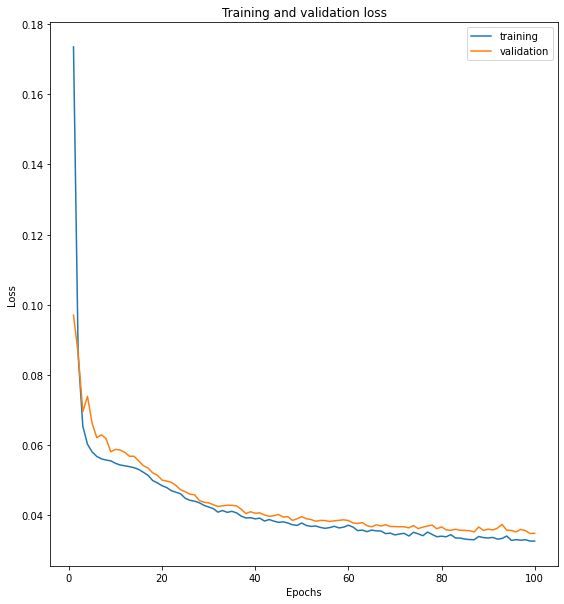

In [ ]:
var_of_interest     = "Transcriptional_Identity"
trial, autoencoder, encoder = find_autoencoder(1,10)
coords  = encoder(gene_expression, training = False)
# tSNE_plot(coords, var_of_interest)

In [ ]:
# @tf.function(experimental_relax_shapes=True)
# def trainstep(model, x_train, optimizer):

#     with tf.GradientTape() as tape:

#         q       = model(x_train, training= True)
#         p       = K.square(q) / K.sum(q, axis=0)
#         p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
#         loss    = K.sum(p*K.log(p/q))

#     grads = tape.gradient(loss, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))

#     return loss

# @tf.function(experimental_relax_shapes=True)
# def teststep(model, x_test, optimizer):

#     q       = model(x_test, training= False)
#     p       = K.square(q) / K.sum(q, axis=0)
#     p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
#     loss    = K.sum(p*K.log(p/q))

#     return loss

data        = gene_expression

# encoder_cluster     = add_cluslayer(encoder, data, 13)

var_of_interest = "Transcriptional_Identity"
results         = encoder(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

input_size  = data.shape[1]
encoder_2   = tf.keras.models.clone_model(encoder)
encoder_2.build(input_shape = (None, input_size))
# encoder_2.set_weights(encoder_cluster.get_weights())
# encoder_2.summary()

encoder_2, train_loss, test_loss    = training(encoder_2, 100)

results         = encoder_2(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

fig = plt.figure(figsize=(10,10))
plt.plot(train_loss, label = 'train loss')
plt.plot(test_loss, label = 'test loss')
plt.legend()

# **VAE**

## Building VAE

In [13]:
def sampling(args):
    z_mean, z_log_sigma = args
    latent_dim = K.shape(z_mean)
    epsilon = K.random_normal(shape=(latent_dim[0], latent_dim[1]),
                              mean=0., stddev=0.005)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [162]:
def VAE(structure):

    # K.clear_session()
    # test            = tf.keras.activations.relu(threshold=0.00001)
    input_dim       = structure["input dimension"]
    hidden_layers_e = structure["hidden layers"]
    hidden_layers_d = hidden_layers_e[::-1]
    latent_dim      = structure["latent dimension size"]

    activation      = structure["activation"]
    drop            = structure["dropout rate"]
    optimizer       = structure["optimizer"]
    lr              = structure["learning rate"]

    input_e         = Input(shape   = (input_dim,), 
                            name    = "Input")
    input_d         = Input(shape   = (latent_dim,), 
                            name    = "Input")
    
    coder_length    = len(hidden_layers_e)
    names_e         = ["Encoding_layer_"]*coder_length
    names_d         = ["Decoding_layer_"]*coder_length


    hidden_layer_e  = Dense(hidden_layers_e[0],
                            kernel_initializer  = glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_e[0], 1))(input_e)
    hidden_layer_d  = Dense(hidden_layers_d[0],
                            kernel_initializer  = glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_d[0], 1))(input_d)


    hidden_layers_e.pop(0)
    hidden_layers_d.pop(0)

    for i in range(len(hidden_layers_e)):
        hidden_layer_e    = Dense(hidden_layers_e[i],
                                kernel_initializer  = glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_e[i], i+2))(hidden_layer_e)
        hidden_layer_d    = Dense(hidden_layers_d[i],
                                kernel_initializer  = glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_d[i], i+2))(hidden_layer_d)
    
    mean    = Dense(latent_dim,
                    kernel_initializer  = glorot_uniform(),
                    activation          = None,
                    name                = "z_mean")(hidden_layer_e)
    log_sigma   = Dense(latent_dim,
                    kernel_initializer  = glorot_uniform(),
                    activation          = None,
                    name                = "z_log_sigma")(hidden_layer_e)
    # sigma_a = Activation(Lambda(lambda x: tf.keras.activations.relu(x, threshold=5)))(sigma)               
    z       = Lambda(sampling, name = "Sampling")([mean, log_sigma])

    output  = Dense(input_dim,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")(hidden_layer_d)     

    # K.clear_session()  
    encoder     = Model(inputs  = input_e, 
                        outputs = [mean, log_sigma, z], 
                        name    = "VAE-encoder")
    decoder     = Model(inputs  = input_d, 
                        outputs = output, 
                        name    = "VAE-decoder")
    
    inputs      = Input(shape   = (input_dim,), 
                        name    = "Input")
    outputs     = decoder(encoder(input_e)[2])
    autoencoder = keras.Model(inputs    = input_e, 
                      outputs   = outputs, 
                      name      = "VAE")
    
    reconstruction_loss = keras.losses.MeanSquaredError()
    kl_loss = 1 + 2 * log_sigma - K.square(mean) - K.square(K.exp(log_sigma))
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss(input_e, outputs) + kl_loss)
    autoencoder.add_loss(vae_loss)
    # autoencoder.add_loss(lambda : 10)
    autoencoder.compile(optimizer=optimizer)
    K.set_value(autoencoder.optimizer.learning_rate, lr)
    # K.set_value(autoencoder.optimizer.clipnorm, 1)
    # K.clear_session()  
    return encoder, decoder, autoencoder

## Training functions

### Training loop

In [ ]:
def training_VAE(model, epochs, optimizer, data = gene_expression):

    @tf.function 
    def trainstep(model, x_train, optimizer, encoder, mse):

        with tf.GradientTape() as tape:

            autoencoding        = model(x_train, training = True)
            # print('ae =',autoencoding)
            ae_loss             = mse(x_train, autoencoding)
            # print('ae loss =',ae_loss)

            # encoder             = Model(inputs  = autoencoder.input,
            #                                 outputs = autoencoder.get_layer("VAE-encoder").output)
            distribution        = encoder(x_train)[:2]
            # print('distri =',distribution)
            mean                = distribution[0]
            log_sigma           = distribution[1]
            num_patients, dim   = mean.shape

            kl_loss               = K.sum(-0.5 - log_sigma + 0.5*K.square(mean) + 0.5*K.square( K.exp(log_sigma) ) )
            # print('kl loss =', kl_loss)
            loss                = ae_loss + kl_loss

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return [loss, kl_loss, ae_loss]

    @tf.function
    def teststep(model, x_test, optimizer, encoder, mse):

        autoencoding        = model(x_test, training = False)
        # print('ae =',autoencoding)
        ae_loss             = mse(x_test, autoencoding)
        # print('ae loss =',ae_loss)

        # encoder             = Model(inputs  = autoencoder.input,
        #                                     outputs = autoencoder.get_layer("VAE-encoder").output)
        distribution        = encoder(x_test)[:2]
        #print('distri =',distribution)
        mean                = distribution[0]
        log_sigma           = distribution[1]
        num_patients, dim   = mean.shape

        kl_loss               = K.sum(-0.5 - log_sigma + 0.5*K.square(mean) + 0.5*K.square( K.exp(log_sigma) ) )

        loss                = ae_loss + kl_loss

        return [loss, kl_loss, ae_loss]
    # print(data)
    input_dim       = data.shape[1]

    data    = pd.DataFrame(data.numpy())
    # data    = pd.DataFrame(normalize(data).numpy())

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    # optimizer = keras.optimizers.Adam(learning_rate= 0.00001, clipnorm = 1)
    mse       = keras.losses.MeanSquaredError()
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = np.empty(shape=(epochs,3))
    loss_test   = np.empty(shape=(epochs,3))

    encoder         = Model(inputs  = model.input,
                            outputs = model.get_layer("VAE-encoder").output)

    for i in range(epochs):


        train_loss      = trainstep(model, x_train, optimizer, encoder, mse)
        loss_train[i]   = train_loss
        test_loss       = teststep(model, x_test, optimizer, encoder, mse)
        loss_test[i]    = test_loss

    return model, loss_train, loss_test

### Training loop (hyperparameter tuning)

In [ ]:
def training_VAE_trial(model, epochs, optimizer, trial, data = gene_expression):

    @tf.function 
    def trainstep(model, x_train, optimizer, encoder, mse):

        with tf.GradientTape() as tape:

            autoencoding        = model(x_train, training = True)
            # print('ae =',autoencoding)
            ae_loss             = mse(x_train, autoencoding)
            # print('ae loss =',ae_loss)

            # encoder             = Model(inputs  = autoencoder.input,
            #                                 outputs = autoencoder.get_layer("VAE-encoder").output)
            distribution        = encoder(x_train)[:2]
            # print('distri =',distribution)
            mean                = distribution[0]
            log_sigma           = distribution[1]
            num_patients, dim   = mean.shape

            kl_loss               = K.sum(-0.5 - log_sigma + 0.5*K.square(mean) + 0.5*K.square( K.exp(log_sigma) ) ) 
            # print('kl loss =', kl_loss)
            loss                = ae_loss + kl_loss

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return [loss, kl_loss, ae_loss]

    @tf.function
    def teststep(model, x_test, optimizer, encoder, mse):

        autoencoding        = model(x_test, training = False)
        # print('ae =',autoencoding)
        ae_loss             = mse(x_test, autoencoding)
        # print('ae loss =',ae_loss)

        # encoder             = Model(inputs  = autoencoder.input,
        #                                     outputs = autoencoder.get_layer("VAE-encoder").output)
        distribution        = encoder(x_test)[:2]
        #print('distri =',distribution)
        mean                = distribution[0]
        log_sigma           = distribution[1]
        num_patients, dim   = mean.shape

        kl_loss               = K.sum(-0.5 - log_sigma + 0.5*K.square(mean) + 0.5*K.square( K.exp(log_sigma) ) )

        loss                = ae_loss + kl_loss

        return [loss, kl_loss, ae_loss]
    # print(data)
    input_dim       = data.shape[1]

    data    = pd.DataFrame(data.numpy())
    # data    = pd.DataFrame(normalize(data).numpy())

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    # optimizer = keras.optimizers.Adam(learning_rate= 0.00001, clipnorm = 1)
    mse       = keras.losses.MeanSquaredError()
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = np.empty(shape=(epochs,3))
    loss_test   = np.empty(shape=(epochs,3))

    encoder         = Model(inputs  = model.input,
                            outputs = model.get_layer("VAE-encoder").output)

    for i in range(epochs):


        train_loss      = trainstep(model, x_train, optimizer, encoder, mse)
        loss_train[i]   = train_loss
        test_loss       = teststep(model, x_test, optimizer, encoder, mse)
        loss_test[i]    = test_loss

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    trial.set_user_attr(key="train_loss", value = loss_train)
    trial.set_user_attr(key="test_loss", value = loss_test)

    return model, loss_train, loss_test

### Activation functions

In [ ]:
def arcsinh(x):
    return K.log(x + K.pow(K.square(x)+1, 0.5))

In [ ]:
def non_zero(x):
    #x = arcsinh(x)
    return K.abs(x) + 0.000001

## Training

### Hyperparameter tuning functions

In [166]:
def hyperpar_tuner_VAE(trial):

    K.clear_session()

    global gene_expression, models

    input_dim       = gene_expression.shape[1]

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    latent_dim      = 2 #trial.suggest_int("latent dimension size", 2, 15)
    activation      = trial.suggest_categorical("activation", ["relu", "selu", "tanh"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = 0 #trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-5, 10**-2)
    # momentum        = trial.suggest_float("momentum", 0, 0.999)

    # if optimizer == "adam":
    #     optimizer   = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum, clipnorm = 1)
    # else:
    #     optimizer   = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum, clipnorm = 1)

    


    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 500)
        hidden_layers.append(hlayer)

    structure = {"input dimension"        :   input_dim,
                 "hidden layers"          :   hidden_layers,
                 "latent dimension size"  :   latent_dim,
                 "activation"             :   activation,
                 "dropout rate"           :   dropout_rate,
                 "learning rate"          :   learning_rate,
                 "optimizer"              :   optimizer}

    encoder, decoder, autoencoder       = VAE(structure)
    autoencoder.build(input_shape=(None,input_dim))
    # autoencoder.summary()

    data    = pd.DataFrame(gene_expression.numpy())

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])
    # autoencoder.add_loss(lambda : 10)

    history = autoencoder.fit(x                 = x_train, 
                              y                 = x_train,
                              epochs            = 200,
                              verbose           = 0,
                              validation_data   = (x_test, x_test))
    
    # trial.set_user_attr(key="history", value = history)
    trial.set_user_attr(key="test_loss", value = history.history["val_loss"])
    trial.set_user_attr(key="train_loss", value = history.history["loss"])

    result  = history.history['val_loss'][-1]

    # autoencoder, train_loss, test_loss  = training_VAE_trial(autoencoder, 500, optimizer, trial)

    models.append(autoencoder)
    # result                              = test_loss[-1, 0]
    # plot_VAE(train_loss, test_loss)

    return result


In [51]:
def find_VAE(n):

    global models, gene_expression
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning VAE")
    study.optimize(hyperpar_tuner_VAE, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    encoder     = Model(inputs  = autoencoder.input,
                            outputs = autoencoder.get_layer("VAE-encoder").output)


    # n_encoding_layers   = trial.params["N_layers"] 
    # encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    # encoder             = Sequential(encoding_layers) 

    
    # kmeans = KMeans(n_clusters= d, n_init=20)
    # kmeans.fit_predict(encoder_DEC.predict(gene_expression)[-1])
    # clustering_layer  = ClusteringLayer(d, name = "cluster")(encoder_DEC.output[-1])
    # encoder_DEC     = Model(inputs  = encoder_DEC.input,
    #                         outputs = clustering_layer)

    # encoder_DEC.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    # encoder_DEC.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return trial, autoencoder, encoder

### Training

[I 2021-11-09 15:48:11,841] A new study created in memory with name: Tuning VAE
[I 2021-11-09 15:48:33,438] Trial 0 finished with value: 0.16422800719738007 and parameters: {'N_layers': 3, 'activation': 'tanh', 'optimizer': 'SGD', 'learning rate': 0.004271518523247685, 'hlay 1': 424, 'hlay 2': 130, 'hlay 3': 373}. Best is trial 0 with value: 0.16422800719738007.


 This is the best trial so far


[W 2021-11-09 15:48:55,038] Trial 1 failed, because the objective function returned nan.
[I 2021-11-09 15:49:16,813] Trial 2 finished with value: 0.05397005379199982 and parameters: {'N_layers': 3, 'activation': 'tanh', 'optimizer': 'adam', 'learning rate': 0.004297797982673118, 'hlay 1': 72, 'hlay 2': 153, 'hlay 3': 171}. Best is trial 2 with value: 0.05397005379199982.


 This is the best trial so far


[I 2021-11-09 15:49:35,665] Trial 3 finished with value: 0.07625064253807068 and parameters: {'N_layers': 5, 'activation': 'tanh', 'optimizer': 'adam', 'learning rate': 0.003024154247450807, 'hlay 1': 377, 'hlay 2': 109, 'hlay 3': 264, 'hlay 4': 447, 'hlay 5': 246}. Best is trial 2 with value: 0.05397005379199982.
[I 2021-11-09 15:49:49,270] Trial 4 finished with value: 0.1630435436964035 and parameters: {'N_layers': 2, 'activation': 'selu', 'optimizer': 'SGD', 'learning rate': 0.007414429245283431, 'hlay 1': 32, 'hlay 2': 188}. Best is trial 2 with value: 0.05397005379199982.
[W 2021-11-09 15:50:11,009] Trial 5 failed, because the objective function returned nan.
[W 2021-11-09 15:50:28,038] Trial 6 failed, because the objective function returned nan.
[I 2021-11-09 15:50:49,742] Trial 7 finished with value: 0.05209380388259888 and parameters: {'N_layers': 3, 'activation': 'tanh', 'optimizer': 'adam', 'learning rate': 0.007145468428864747, 'hlay 1': 393, 'hlay 2': 265, 'hlay 3': 199}. B

 This is the best trial so far


[I 2021-11-09 15:51:05,127] Trial 8 finished with value: 0.18211598694324493 and parameters: {'N_layers': 4, 'activation': 'tanh', 'optimizer': 'SGD', 'learning rate': 0.00292953404085871, 'hlay 1': 158, 'hlay 2': 61, 'hlay 3': 145, 'hlay 4': 375}. Best is trial 7 with value: 0.05209380388259888.
[I 2021-11-09 15:51:21,589] Trial 9 finished with value: 12.29944133758545 and parameters: {'N_layers': 3, 'activation': 'tanh', 'optimizer': 'adam', 'learning rate': 0.00601702060132392, 'hlay 1': 134, 'hlay 2': 309, 'hlay 3': 465}. Best is trial 7 with value: 0.05209380388259888.


Number of finished trials: 10
Best trial:
  Value: 0.05209380388259888
  Params: 
    N_layers: 3
    activation: tanh
    optimizer: adam
    learning rate: 0.007145468428864747
    hlay 1: 393
    hlay 2: 265
    hlay 3: 199


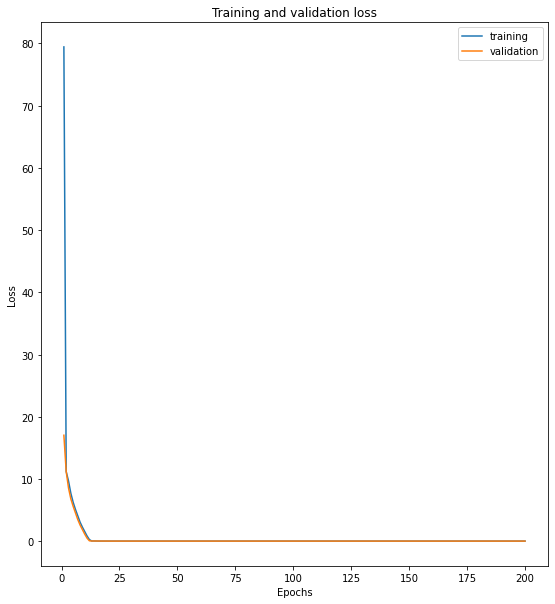

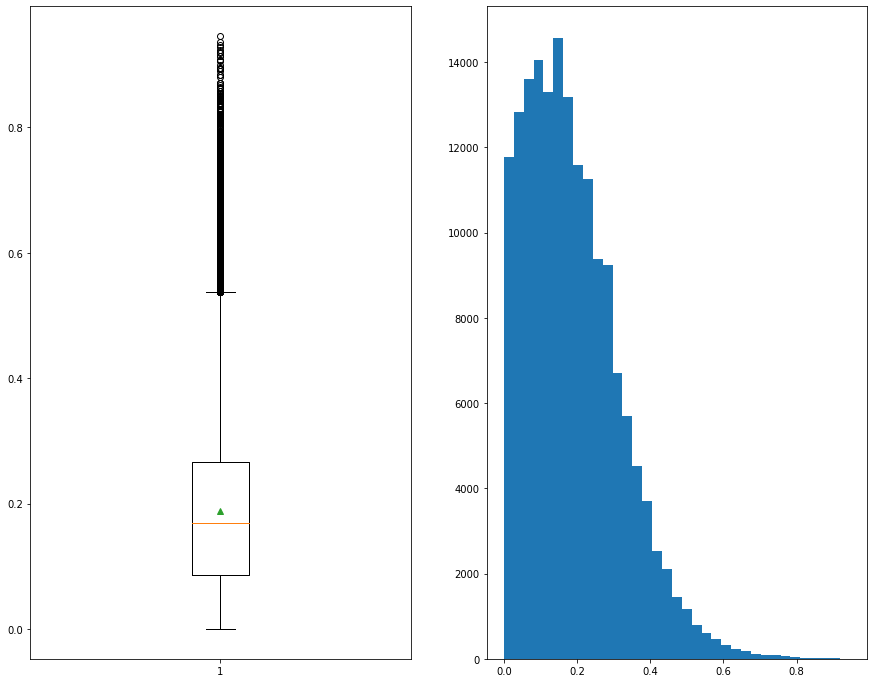

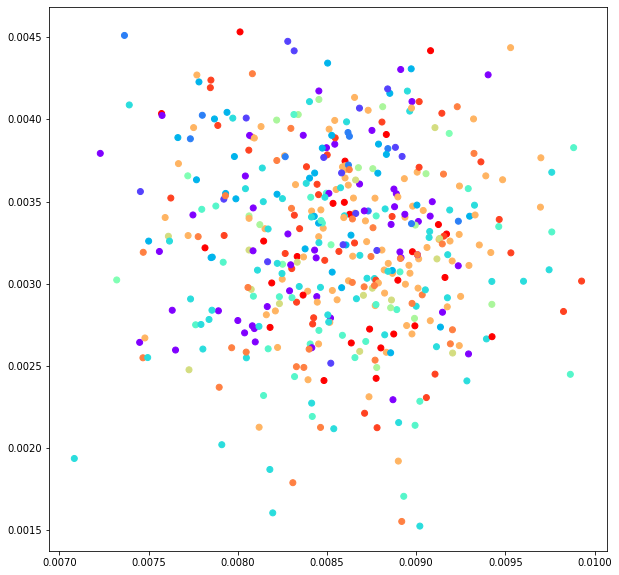

In [129]:
experiment, vae, encoder = find_VAE(10)
test_loss = experiment.user_attrs["test_loss"]
train_loss= experiment.user_attrs["train_loss"]
plot_VAE_2(train_loss, test_loss)
output = vae(gene_expression)
vis_dif(gene_expression, output)
coords = encoder(gene_expression)[-1]
vis_clus(coords, patient_data, "Transcriptional_Identity")

# **VAE (supervised clustering)**

## Building VAE

In [2]:
def sampling_sc(args):
    z_mean, z_log_sigma = args
    latent_dim = K.shape(z_mean)
    epsilon = K.random_normal(shape=(latent_dim[0], latent_dim[1]),
                              mean=0., stddev=0.0005)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [33]:
def VAE_sc(structure, y_train):

    # K.clear_session()
    # test            = tf.keras.activations.relu(threshold=0.00001)
    input_dim       = structure["input dimension"]
    hidden_layers_e = structure["hidden layers"]
    hidden_layers_d = hidden_layers_e[::-1]
    latent_dim      = structure["latent dimension size"]

    activation      = structure["activation"]
    drop            = structure["dropout rate"]
    optimizer       = structure["optimizer"]
    lr              = structure["learning rate"]
    n_cluster       = structure["number of clusters"]      

    input_e         = Input(shape   = (input_dim,), 
                            name    = "Input")
    input_d         = Input(shape   = (latent_dim,), 
                            name    = "Input")
    
    coder_length    = len(hidden_layers_e)
    names_e         = ["Encoding_layer_"]*coder_length
    names_d         = ["Decoding_layer_"]*coder_length


    hidden_layer_e  = Dense(hidden_layers_e[0],
                            kernel_initializer  = None, #glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_e[0], 1))(input_e)
    hidden_layer_d  = Dense(hidden_layers_d[0],
                            kernel_initializer  = None, #glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_d[0], 1))(input_d)


    hidden_layers_e.pop(0)
    hidden_layers_d.pop(0)

    for i in range(len(hidden_layers_e)):
        hidden_layer_e    = Dense(hidden_layers_e[i],
                                kernel_initializer  = None, #glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_e[i], i+2))(hidden_layer_e)
        hidden_layer_d    = Dense(hidden_layers_d[i],
                                kernel_initializer  = None, #glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_d[i], i+2))(hidden_layer_d)
    
    mean        = Dense(latent_dim,
                        kernel_initializer  = None, #glorot_uniform(),
                        activation          = None,
                        name                = "z_mean")(hidden_layer_e)
    log_sigma   = Dense(latent_dim,
                        kernel_initializer  = None, #glorot_uniform(),
                        activation          = None,
                        name                = "z_log_sigma")(hidden_layer_e)
    # sigma_a = Activation(Lambda(lambda x: tf.keras.activations.relu(x, threshold=5)))(sigma)               
    z       = Lambda(sampling_sc, name = "Sampling")([mean, log_sigma])

    classification  = Dense(n_cluster,
                            kernel_initializer  = None,
                            activation          = "softmax",
                            name                = "classification_layer")(z)

    output  = Dense(input_dim,
                    kernel_initializer  = None, #glorot_uniform(),
                    activation          = activation,
                    name                = "Output")(hidden_layer_d)     

    # K.clear_session()  
    encoder     = Model(inputs  = input_e, 
                        outputs = [mean, log_sigma, z], 
                        name    = "VAE-encoder")
    decoder     = Model(inputs  = input_d, 
                        outputs = output, 
                        name    = "VAE-decoder")
    
    inputs      = Input(shape   = (input_dim,), 
                        name    = "Input")
    outputs     = decoder(encoder(input_e)[2])
    autoencoder = keras.Model(inputs    = input_e, 
                      outputs   = outputs, 
                      name      = "VAE")
    
    reconstruction_loss = keras.losses.MeanSquaredError()
    classification_loss = keras.losses.CategoricalCrossentropy()
    kl_loss = 1 + 2 * log_sigma - K.square(mean) - K.square(K.exp(log_sigma))
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss(input_e, outputs) + kl_loss)
    autoencoder.add_loss(vae_loss)
    # autoencoder.add_loss(lambda : 10)
    autoencoder.add_loss(lambda : classification_loss(y_train, classification))
    autoencoder.compile(optimizer=optimizer)
    K.set_value(autoencoder.optimizer.learning_rate, lr)
    # K.clear_session()  
    return encoder, decoder, autoencoder

## Training

### Hyperparameter tuning functions

In [17]:
def hyperpar_tuner_VAE_sc(trial):

    K.clear_session()

    global gene_expression, models, patient_data_cat

    labels = np.sort(np.unique(patient_data_cat))

    input_dim       = gene_expression.shape[1]

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    latent_dim      = 2 #trial.suggest_int("latent dimension size", 2, 15)
    activation      = trial.suggest_categorical("activation", ["relu", "selu", "tanh"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = 0 #trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-5, 10**-2)
    # momentum        = trial.suggest_float("momentum", 0, 0.999)

    # if optimizer == "adam":
    #     optimizer   = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum, clipnorm = 1)
    # else:
    #     optimizer   = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum, clipnorm = 1)

    


    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 500)
        hidden_layers.append(hlayer)

    structure = {"input dimension"        :   input_dim,
                 "hidden layers"          :   hidden_layers,
                 "latent dimension size"  :   latent_dim,
                 "activation"             :   activation,
                 "dropout rate"           :   dropout_rate,
                 "learning rate"          :   learning_rate,
                 "optimizer"              :   optimizer,
                 "number of clusters"     :   len(labels)}

    data    = pd.DataFrame(gene_expression.numpy())

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    y_train     = tf.convert_to_tensor(patient_data_cat.iloc[ind_shuffle][:train_size])
    y_train     = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(y_train)]))
    x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])

    encoder, decoder, autoencoder       = VAE_sc(structure, y_train)
    autoencoder.build(input_shape=(None,input_dim))
    # autoencoder.summary()

    history = autoencoder.fit(x                 = x_train, 
                              y                 = x_train,
                              epochs            = 200,
                              verbose           = 0,
                              validation_data   = (x_test, x_test))
    
    # trial.set_user_attr(key="history", value = history)
    trial.set_user_attr(key="test_loss", value = history.history["val_loss"])
    trial.set_user_attr(key="train_loss", value = history.history["loss"])

    result  = history.history['val_loss'][-1]

    # autoencoder, train_loss, test_loss  = training_VAE_trial(autoencoder, 500, optimizer, trial)

    models.append(autoencoder)
    # result                              = test_loss[-1, 0]
    # plot_VAE(train_loss, test_loss)

    return result


In [18]:
def find_VAE_sc(n):

    global models, gene_expression
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning VAE")
    study.optimize(hyperpar_tuner_VAE_sc, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    encoder     = Model(inputs  = autoencoder.input,
                            outputs = autoencoder.get_layer("VAE-encoder").output)


    # n_encoding_layers   = trial.params["N_layers"] 
    # encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    # encoder             = Sequential(encoding_layers) 

    
    # kmeans = KMeans(n_clusters= d, n_init=20)
    # kmeans.fit_predict(encoder_DEC.predict(gene_expression)[-1])
    # clustering_layer  = ClusteringLayer(d, name = "cluster")(encoder_DEC.output[-1])
    # encoder_DEC     = Model(inputs  = encoder_DEC.input,
    #                         outputs = clustering_layer)

    # encoder_DEC.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    # encoder_DEC.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return trial, autoencoder, encoder

### Training

In [34]:
var_of_interest = "Transcriptional_Identity"
patient_data_cat = patient_data[var_of_interest]

labels      = labels = np.sort(np.unique(patient_data_cat))
structure = {"input dimension"        :   381,
             "hidden layers"          :   [256, 128, 64, 32],    # list of integers denoting the size of the hidden layers
             "latent dimension size"  :   2,    # integer denoting size of the latent dimension
             "activation"             :   'selu',    # string, e.g relu/selu etc
             "dropout rate"           :   0.5,
             "learning rate"          :   0.001,
             "optimizer"              :   "adam",
             "number of clusters"     :   len(labels)}    # float, dropout is however not yet implemented, as overfitting does not seem very significant when the network structure is right
y_train     = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(patient_data_cat)]))
y_train     = tf.convert_to_tensor(y_train)
encoder, decoder, vae       = VAE_sc(structure, y_train)

history = vae.fit(gene_expression, gene_expression,
        epochs=200,
        verbose = 0)

plot(history)

TypeError: ignored

In [21]:
var_of_interest = "Transcriptional_Identity"
patient_data_cat = patient_data[var_of_interest]
experiment, vae, encoder = find_VAE_sc(10)
test_loss = experiment.user_attrs["test_loss"]
train_loss= experiment.user_attrs["train_loss"]
plot_VAE_2(train_loss, test_loss)
output = vae(gene_expression)
vis_dif(gene_expression, output)
coords = encoder(gene_expression)[-1]
vis_clus(coords, patient_data, var_of_interest)

[I 2021-11-09 17:39:19,483] A new study created in memory with name: Tuning VAE
[W 2021-11-09 17:39:20,488] Trial 0 failed because of the following error: ValueError('in user code:\n\n    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 878, in train_function  *\n        return step_function(self, iterator)\n    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 867, in step_function  **\n        outputs = model.distribute_strategy.run(run_step, args=(data,))\n    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 860, in run_step  **\n        outputs = model.train_step(data)\n    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 810, in train_step\n        y, y_pred, sample_weight, regularization_losses=self.losses)\n    File "/usr/local/lib/python3.7/dist-packages/keras/engine/compile_utils.py", line 231, in __call__\n        reg_loss = tf.add_n(regularization_losses)\n    File 

ValueError: ignored

# **Training without hyp. tuning**

Epoch 1/200
14/14 [==============================] - 1s 6ms/step - loss: 26.2326
Epoch 2/200
14/14 [==============================] - 0s 6ms/step - loss: 15.6192
Epoch 3/200
14/14 [==============================] - 0s 6ms/step - loss: 11.2496
Epoch 4/200
14/14 [==============================] - 0s 6ms/step - loss: 10.3532
Epoch 5/200
14/14 [==============================] - 0s 6ms/step - loss: 10.2025
Epoch 6/200
14/14 [==============================] - 0s 6ms/step - loss: 10.1560
Epoch 7/200
14/14 [==============================] - 0s 6ms/step - loss: 10.1429
Epoch 8/200
14/14 [==============================] - 0s 6ms/step - loss: 10.1295
Epoch 9/200
14/14 [==============================] - 0s 6ms/step - loss: 10.1238
Epoch 10/200
14/14 [==============================] - 0s 6ms/step - loss: 10.1178
Epoch 11/200
14/14 [==============================] - 0s 6ms/step - loss: 10.1160
Epoch 12/200
14/14 [==============================] - 0s 6ms/step - loss: 10.1111
Epoch 13/200
14/14 [=====

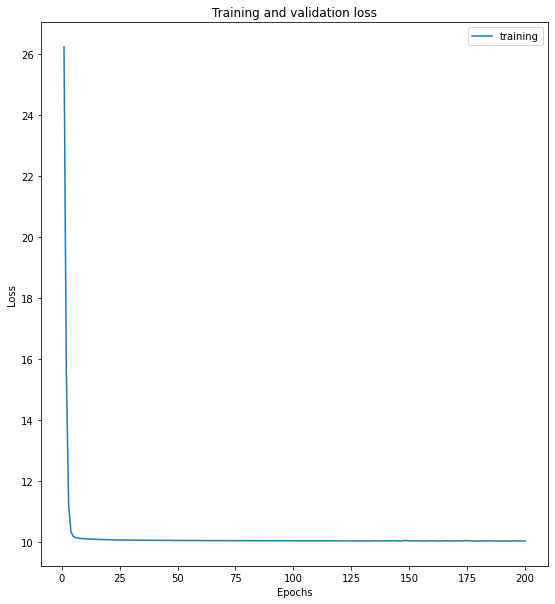

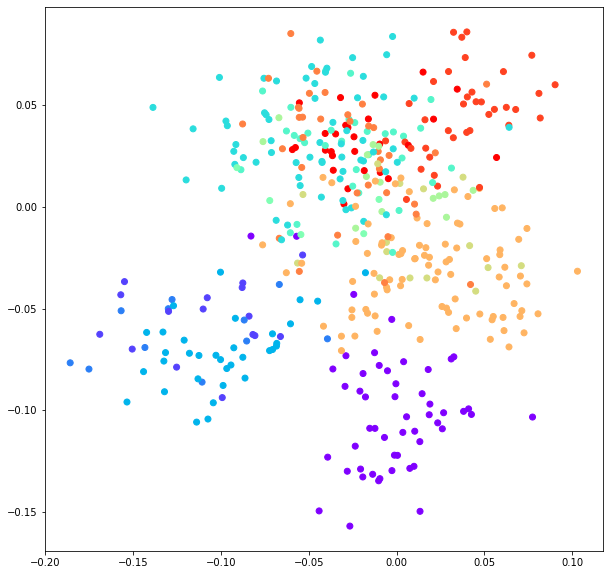

In [165]:
input_dim = gene_expression.shape[1]
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
structure = {"input dimension"        :   input_dim,
             "hidden layers"          :   [256, 128, 64, 32],    # list of integers denoting the size of the hidden layers
             "latent dimension size"  :   2,    # integer denoting size of the latent dimension
             "activation"             :   'selu',    # string, e.g relu/selu etc
             "dropout rate"           :   0.5,
             "learning rate"          :   0.001,
             "optimizer"              :   "adam"}    # float, dropout is however not yet implemented, as overfitting does not seem very significant when the network structure is right
encoder, decoder, vae       = VAE(structure)

history = vae.fit(gene_expression, gene_expression,
        epochs=200,
        verbose = 1)

plot(history)
 
# autoencoder, train_loss, test_loss  = training_VAE(autoencoder, 
#                                                    500, 
#                                                    optimizer)
# plot_VAE(train_loss, test_loss)

# encoder  = Model(inputs  = encoder_dec.input,
#                 outputs = encoder_dec.get_layer("Sampling").output)
# encoder.summary()

var_of_interest = "Transcriptional_Identity"
patientdat = patient_data[var_of_interest]
labels = patientdat.astype('category').cat.codes.to_list()
num_colors = len(np.unique(labels))
colors = plt.get_cmap('rainbow', num_colors)

coords = encoder(gene_expression)[0] # the output of the encoder is a tuple containing the (means, sigma's, sampling)
fig = plt.figure(figsize=(10,10))
plt.scatter(coords[:,0],coords[:,1], c= colors(labels))